In [1]:
%load_ext autoreload
%autoreload 2

import music21 as mu
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from data_helper import *
from music_helper import *

### Bachセット

In [2]:
pathes = [
    './tmp/Result_FHMM1/{dataId:03d}-1_fingering.txt',
    './tmp/Result_FHMM2/{dataId:03d}-1_fingering.txt',
    './tmp/Result_FHMM3/{dataId:03d}-1_fingering.txt',
    "./tmp/PianoFingeringDataset/FingeringFiles/{dataId:03d}-1_fingering.txt",
    "./tmp/PianoFingeringDataset/FingeringFiles/{dataId:03d}-2_fingering.txt",
    "./tmp/PianoFingeringDataset/FingeringFiles/{dataId:03d}-5_fingering.txt",
    "./tmp/PianoFingeringDataset/FingeringFiles/{dataId:03d}-8_fingering.txt",
]
players = [
    "FHMM1","FHMM2","FHMM3",
    "PIG_1","PIG_2","PIG_5","PIG_8",
]
works = [
    "Two-part invention in C major",
    "Two-part invention in F major",
    "Well-Tempered Clavier, Book I, Prelude No. 23 in B major",
    "Well-Tempered Clavier, Book II, Fugue No. 2 in C minor",
    "Well-Tempered Clavier, Book II, Fugue No. 19 in A major",
    "Partita No. 6 Corrente",
    "French Suite No. 1 Allemande",
    "French Suite No. 5 Sarabande",
    "English Suite No. 3 Prelude",
    "Goldberg Variations, Variation 13",
]
bachTables = {}
for playerId, name in enumerate(players):
    bachTables[name] = [read_PIG(pathes[playerId].format(dataId = mi + 1)) for mi in range(10)]

## 運指要素

In [5]:
columns = ["寄せ", "拡げ", "潜り", "超え", "その他"]
total = np.zeros(shape = (len(players), len(columns)))
for playerId, name in enumerate(players):
    tables = bachTables[name]
    for ch in [0, 1]:
        actions = np.zeros(len(columns))
        for table in tables:
            notes = table[table.ch == ch]
            rest = False
            for pi in range(1, len(notes)):
                n = notes.iloc[pi]
                n_ = notes.iloc[pi - 1]
                td_ = n.t0 - n_.t1
                if td_ >= 1 / 32: # 休符を挟まない
                    rest = True
                    continue
                if not rest:
                    move = getMoveTypeByPIGNote(n, n_)
                    actions[move] += 1
                rest = False
        total[playerId] += actions

In [8]:
dfa = pd.DataFrame(total / 10, columns=columns, index=players)
dfa

,寄せ,拡げ,潜り,超え,その他
FHMM1,3.6,86.5,10.7,9.4,235.3
FHMM2,4.9,81.9,10.2,8.9,239.6
FHMM3,5.6,83.2,11.4,9.5,235.8
PIG_1,19.9,70.2,12.7,9.2,233.3
PIG_2,28.0,53.7,10.9,9.6,242.9
PIG_5,15.9,71.1,11.3,9.8,236.6
PIG_8,21.5,66.8,10.5,10.4,235.0


### 手の移動

In [10]:
costs = np.zeros(shape = (len(works), len(players)))
ch = 0
for ni, name in enumerate(players):
    tables = bachTables[name]
    for wi, table in enumerate(tables):
        notes = table[table.ch == 0]
        rest = False
        sign = np.sign(ch + 0.5)
        hp = (notes.iloc[0].pos + (3 * sign) - notes.iloc[0].fingers[0])
        for pi in range(1, len(notes)):
            n = notes.iloc[pi]
            n_ = notes.iloc[pi - 1]
            td_ = n.t0 - n_.t1
            #if td_ >= 1 / 32: # 休符を挟まない
            #    rest = True
            #    continue
            if not rest:
                pd_ = n.pos - n_.pos
                fd_ = (n.fingers[0] - n_.fingers[-1])
                new_hp = ((n.pos + (3 * sign) - n.fingers[0]) + (n_.pos + (3 * sign) - n_.fingers[-1])) / 2
                move = new_hp - hp
                costs[wi, ni] += abs(move)
                hp = new_hp
            rest = False

<AxesSubplot:>

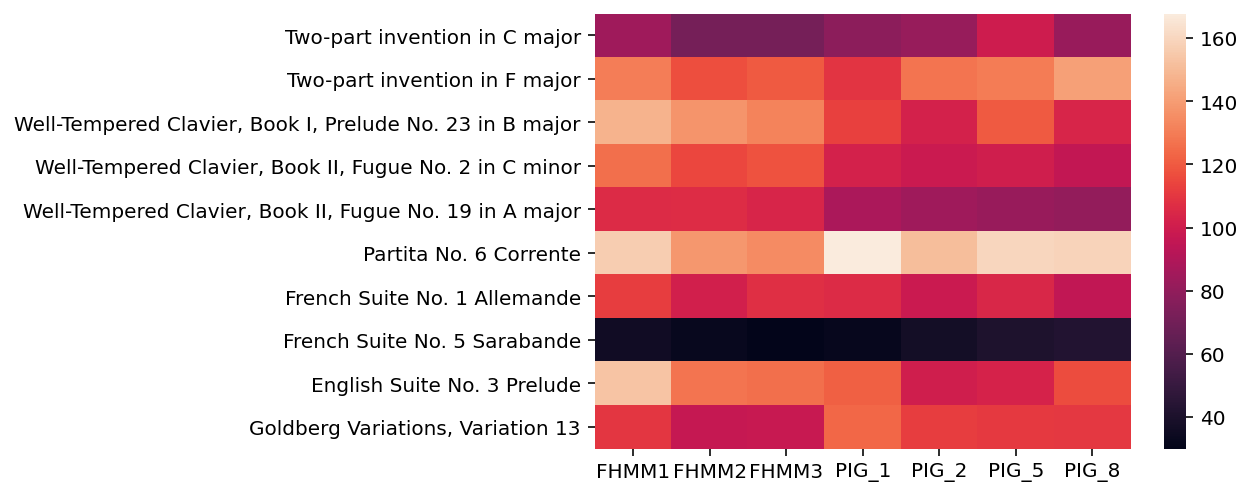

In [12]:
dfa = pd.DataFrame(costs, columns=players, index=works)
sns.heatmap(dfa)